In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data//yellow_tripdata_2016-05.csv",parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime']);
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [3]:
df['tpep_pickup_datetime'] = pd.DatetimeIndex(df['tpep_pickup_datetime']).round('1H') 

Ищем поездки без пассажиров

In [4]:
inds = df[df.passenger_count ==0].index;
print 'No passengers: ',len(inds),' trips';
df.drop(inds,inplace = True);

No passengers:  604  trips


Ищем поездки нулевой длительности

In [5]:
# create additional column - duration of the trip
df = df.assign(duration = df.tpep_dropoff_datetime - df.tpep_pickup_datetime);
# delete empty trips
inds = df[df.duration == pd.to_timedelta('0 days')].index;
print 'Zero duration: ',len(inds),' trips';
df.drop(inds,inplace = True);

Zero duration:  3296  trips


Ищем поездки с нулевым расстоянием по счётчику

In [6]:
# delete empty trips
inds = df[df.trip_distance == 0].index;
print 'Zero distance: ',len(inds),' trips';
df.drop(inds,inplace = True);

Zero distance:  72448  trips


Ищем поездки за пределами Нью-Йорка

In [7]:
#load coordinates of regions
regs = pd.read_csv("data\\regions.csv",sep=";",index_col='region');
# find corners of the New-York rectangular
east = regs.loc[:,'east'].max();
west = regs.loc[:,'west'].min();
south = regs.loc[:,'south'].min();
north = regs.loc[:,'north'].max();
# find outliers
inds = df[(df.pickup_longitude>east) | (df.pickup_longitude<west) | (df.pickup_latitude>north) | (df.pickup_latitude<south)].index;
df.drop(inds,inplace=True);

In [8]:
east

-73.700009999999992

In [9]:
west

-74.255589999999998

In [10]:
south

40.496119999999998

In [11]:
north

40.915529999999997

3) Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

In [8]:
# Сопоставляем регион и координаты посадки для каждой поездки.
# Добавляем данные о номере региона как новый столбец.
from scipy.stats import binned_statistic_2d

X = np.unique([regs.west,regs.east]);
Y = np.unique([regs.south,regs.north]);

[statistic, xEdge, yEdge, binNum] = binned_statistic_2d(df.pickup_longitude,df.pickup_latitude,
        df.index,statistic = 'count',bins = [X,Y],expand_binnumbers = True);
df = df.assign(regions = (binNum[0,:]-1)*(X.size-1)+binNum[1,:]);
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,regions
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,...,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,00:17:31,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,...,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,00:07:31,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,...,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,00:07:01,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,...,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,00:19:47,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,...,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,00:06:39,1130


In [9]:
# группируем данные по региону и часу посадки
gr = df.groupby(['regions', df.tpep_pickup_datetime]);
# считаем количество поездок в каждой мультигруппе
tripCount = gr.VendorID.agg({'count':'count'});
# заполняем нули. Для этого создаём новый индекс - произведение всех регионов на 24 часа
new_index = pd.MultiIndex.from_product([regs.index,pd.date_range('5/1/2016 00:00:00', '5/31/2016 23:59:59',freq='H')])
tripCount = tripCount.reindex(new_index,fill_value = 0,copy = False).rename_axis(['Region','date']);

 4) Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [10]:
# первые строки пустые :)
tripCount.head()

count
Region date                      
1      2016-05-01 00:00:00      0
       2016-05-01 01:00:00      0
       2016-05-01 02:00:00      0
       2016-05-01 03:00:00      0
       2016-05-01 04:00:00      0

In [11]:
# выведем непустые строки
tripCount[tripCount['count'] > 0].head()

,,count
Region,date,
15,2016-05-20 14:00:00,1
16,2016-05-23 09:00:00,1
25,2016-05-04 14:00:00,1
27,2016-05-30 04:00:00,1
32,2016-05-01 18:00:00,1


5) Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

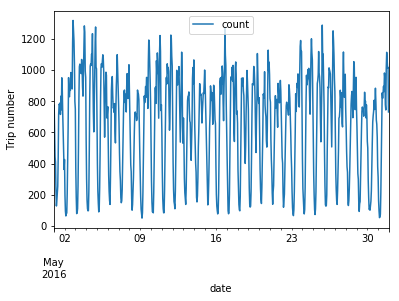

In [12]:
# координаты Empire State Building
coord = [-73.9857012, 40.7488006];
[c1, c2, c3, binId] = binned_statistic_2d([coord[0]],[coord[1]],1,statistic = 'count',bins = [X,Y],expand_binnumbers = True);
binId = (binId[0,:]-1)*(X.size-1)+binId[1,:]
tripCount.loc[int(binId)].plot();
plt.ylabel('Trip number');

6) Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [13]:
print 'Количество пар час-ячейка с нулевым количество поездок ', len(tripCount[tripCount['count'] == 0])

Количество пар час-ячейка с нулевым количество поездок  1718130


In [14]:
tripCount.to_pickle('May2016-aggregate.pcl');